In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def exact_solution(t):
    return 50/81 + (5/9) * t + (31/81)*torch.exp(9*t) - 2*torch.exp(t)


def PINN(NN, domain, num_train, learning_rate, num_itrs, num_test, itr_show):
    model = NN
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    t = torch.linspace(domain[0], domain[1], num_train)
    t = t.view(t.shape[0], 1)

    for itr in range(num_itrs):
        t.requires_grad = True
        
        f = model(t)
        df = grad(f,t)[0]
        df2 = grad(df, t)[0]

        loss = torch.mean((df2 - 10*df + 9*f -5*t)**2) + 10*torch.mean((f[0] + 1)**2) + 10*torch.mean((df[0] - 2)**2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (itr) % itr_show == 0:
            print(f'iteration {itr}/{num_itrs}, loss = {loss}')
    

    t = torch.linspace(domain[0], domain[1],num_test)
    t = t.view(t.shape[0], 1)
    predicted = model(t)
    analytic_cal = exact_solution(t)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t.detach().numpy(), analytic_cal.detach().numpy(), "r",label="exact")
    ax.plot(t.detach().numpy(), predicted.detach().numpy(), "b--", label="predicted")
    ax.set(label="t", ylabel="$F_t$")
    ax.legend()
    plt.show()

In [4]:
torch.manual_seed(42)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size) # input layer
        self.l2 = nn.Linear(hidden_size, hidden_size) # hidden layer 1
        self.l3 = nn.Linear(hidden_size, hidden_size) # hidden layer 2
        self.l4 = nn.Linear(hidden_size, output_size) # hidden layer 3 and output layer
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l4(out)
        return out
        
input_size, hidden_size, output_size = 1, 50, 1
NN = NeuralNet(input_size, hidden_size, output_size)

iteration 0/1500, loss = 50.272701263427734
iteration 100/1500, loss = 43.987831115722656
iteration 200/1500, loss = 43.93450927734375
iteration 300/1500, loss = 43.817298889160156
iteration 400/1500, loss = 40.99604797363281
iteration 500/1500, loss = 11.116582870483398
iteration 600/1500, loss = 1.7956477403640747
iteration 700/1500, loss = 0.9163572788238525
iteration 800/1500, loss = 0.6120603680610657
iteration 900/1500, loss = 0.4083738923072815
iteration 1000/1500, loss = 0.2019193321466446
iteration 1100/1500, loss = 0.1302408128976822
iteration 1200/1500, loss = 0.04635921120643616
iteration 1300/1500, loss = 0.023659517988562584
iteration 1400/1500, loss = 0.009726125746965408


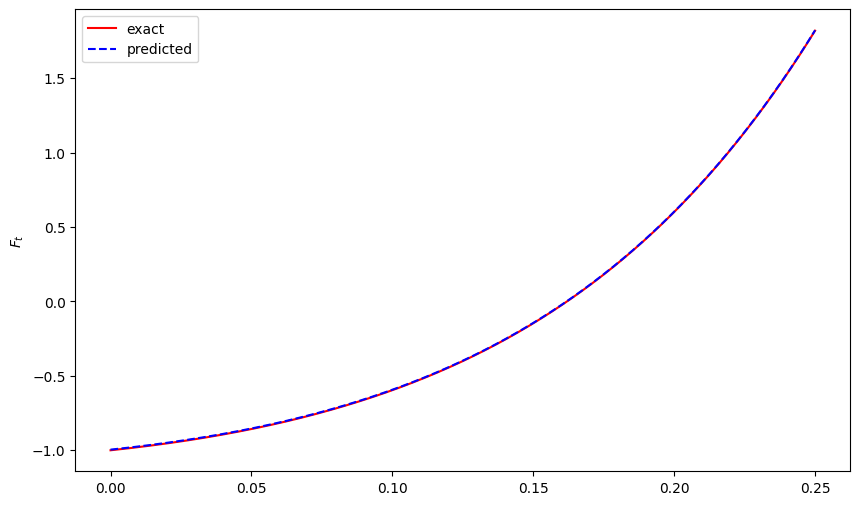

In [5]:
domain = (0, 0.25)
num_train = 1000
num_test = 2000
learning_rate = 0.001
num_itrs = 1500
PINN(NN, domain, num_train, learning_rate, num_itrs, num_test, itr_show=100)